# BASIC CONFIGURATIONS

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_0',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099,
        pciePgpEn  = True,
)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
Root.pciePgp.AxiPcieCore.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000000
UpTime       = 0:26:40
GitHash      = 0x274c06678fe871931cc63e1b56da71ccd4968cfa
XilinxDnaId  = 0x400200000139d7204c80e045
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Tue 10 Oct 2023 03:59:14 PM PDT
Builder      = dnajjar
###################################################


In [3]:
#Run this from a teminal in your localhost without the (!). If you run it here, it will open on rdsrv314 Jupyter server terminal and you won't see it.
#!python -m pyrogue gui --server='rdsrv314:9099'

In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG = [None] * 4
PKREG[0] = ASICTOP.DigAsicStrmRegisters0
PKREG[1] = ASICTOP.DigAsicStrmRegisters1
PKREG[2] = ASICTOP.DigAsicStrmRegisters2
PKREG[3] = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [4]:
# Set & Read ScratchPad
print(hex(AXIV.ScratchPad.get()))
AXIV.ScratchPad.set(0xdeadbeef)
print(hex(AXIV.ScratchPad.get()))

0x0
0xdeadbeef


In [5]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([3,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Root.Core.Si5345Pll.LoadCsvFile(): /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/EPixHRM320KPllConfig168Mhz.csv
Loaded. Waiting for lock...
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet register configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/

# Disable full rate receivers for now

In [6]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

In [7]:
#run some triggers and exercise lanes and locks
frames = 5000
rate = 1000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 5000
Stop Triggers command executed


In [8]:
#get locked lanes
root.getLaneLocks()

ASIC0: 0xffffff
ASIC1: 0xfffffe
ASIC2: 0x36ffff
ASIC3: 0xffffff


# Clear PGP and DigAsicStrmReg counters

In [5]:
def clearPpg():
    for i in range(8):
        root.pciePgp.Lane[i].Ctrl.CountReset()

def clearDigAsicStrmReg():
    for i in range(4):
        PKREG[i].CountReset()

In [6]:
clearPpg()
clearDigAsicStrmReg()

# Release a number of frames on max rate

In [4]:
ssdPath = "/u1/ePixHRM320k/acquisition"
filename = f"{ssdPath}/maxRate11.dat"

In [7]:
root.enableAllAsics(True)
#root.enableDataDebug(True)
#DEBUG0.cleanData()
#DEBUG1.cleanData()
#DEBUG2.cleanData()
#DEBUG3.cleanData()

frames = 1
rate = 5000

#root.hwTrigger(frames, rate)
root.acquireToFile(filename, frames, rate)

Acquisition started: filename: /u1/ePixHRM320k/acquisition/maxRate11.dat, rate: 5000, #frames:1
Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 1
Stop Triggers command executed
Received on channel 0 1 frames...
Received on channel 1 1 frames...
Received on channel 2 1 frames...
Received on channel 3 1 frames...
Waiting for file to close...
Acquisition complete and file closed


# Examine pgpcard and DigAsicStrmReg

In [8]:
def getPgpFrmCnt():
    frmCnt = [None] * 4
    for i in range(4):
        frmCnt[i] = root.pciePgp.Lane[i].RxStatus.FrameCnt.get()
    return frmCnt

def getDigAsicStrmRegFrmCnt():
    frmCnt = [None] * 4
    for i in range(4): 
        frmCnt[i] = PKREG[i].FrameCount.get()
    return frmCnt

In [9]:
digAsicStrmRegFrmCnt = getDigAsicStrmRegFrmCnt()
print("Firmware counted {}".format(digAsicStrmRegFrmCnt))
pgpFrmCnt = getPgpFrmCnt()
print("Pgpcard counted {}".format(pgpFrmCnt))

Firmware counted [1, 1, 1, 1]
Pgpcard counted [1, 1, 1, 1]


In [10]:
# Has good performance

root.readFromFile(filename)

readerReceiver[3] has channel 2
readerReceiver[2] has channel 2
readerReceiver[0] has channel 2
readerReceiver[1] has channel 2


In [11]:
np.shape(root.readerReceiver.getData())

(192, 384, 4, 10000)

TypeError: Invalid shape (192, 384, 10000) for image data

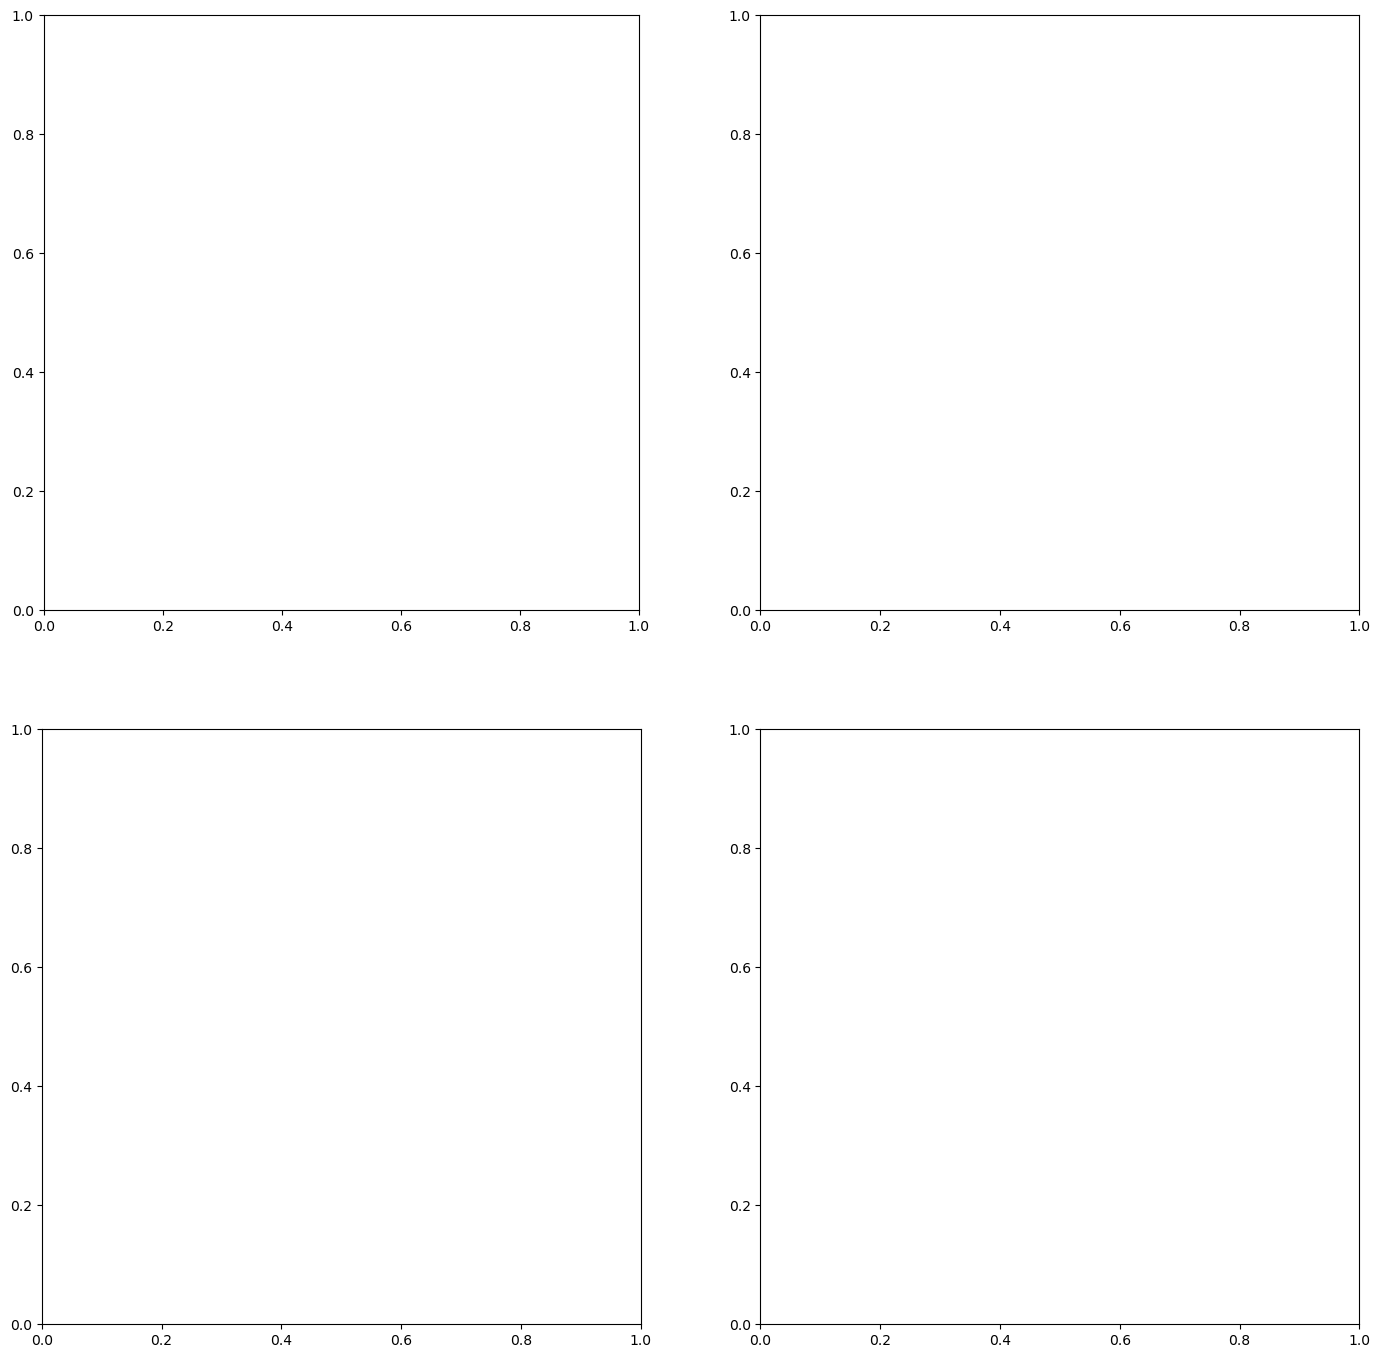

In [32]:
plt.subplots(2,2,figsize=(17,17))
for imageIndex in range(4):
    plt.subplot(2,2,imageIndex+1)
     
    plt.imshow(root.readerReceiver.getData()[:,:,imageIndex], interpolation='nearest')
    #plt.xlabel("ASIC {} frame 0".format(imageIndex))
    plt.colorbar()

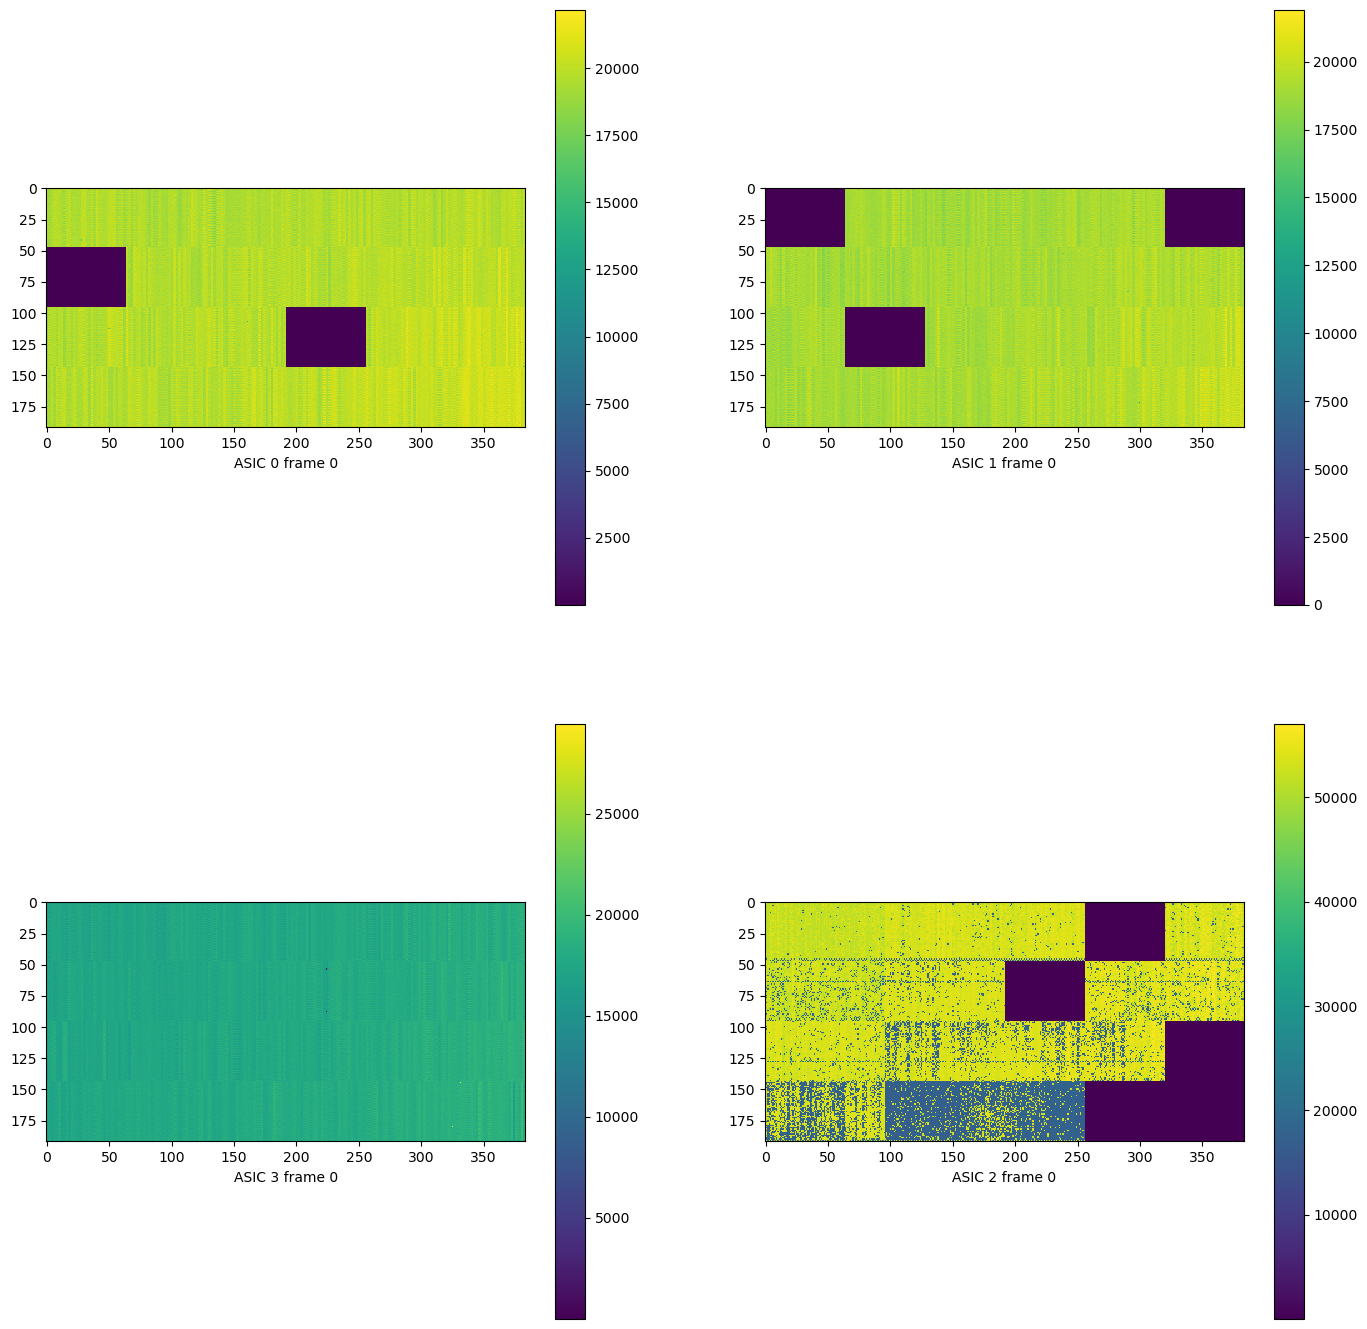

In [30]:
plt.subplots(2,2,figsize=(17,17))

plt.subplot(2,2,1)
plt.imshow(DEBUG0.getData()[:,:,0], interpolation='nearest')
plt.xlabel("ASIC 0 frame 0")
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(DEBUG1.getData()[:,:,0], interpolation='nearest')
plt.xlabel("ASIC 1 frame 0")
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(DEBUG2.getData()[:,:,0], interpolation='nearest')
plt.xlabel("ASIC 2 frame 0")
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(DEBUG3.getData()[:,:,0], interpolation='nearest')
plt.xlabel("ASIC 3 frame 0")
plt.colorbar()
